# Collaborative filter example using beeradvocate data

## import packages and load in the dataset

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dir_name = '/Users/mbeckert/Documents/code/insight_beer/data/'
beer_df = pd.read_csv(dir_name + 'beer_reviews.csv')

## trim down the data to remove users and beer styles which have very few reviews

Note that all beer styles have lots of reviews (min = 241)

In [76]:
beers = beer_df.groupby('beer_style')['beer_style'].count()
beers = beers.index[beers.sort_values() > 10]
beer_df = beer_df[beer_df.beer_style.isin(beers)]

In [77]:
users = beer_df.groupby('review_profilename')['beer_beerid'].count()
users = users.index[users.sort_values() > 150]
beer_df = beer_df[beer_df.review_profilename.isin(users)]

In [78]:
del users, beers

## Get some info for the creation of the review matrix for the collaborative filter

In [79]:
n_users = beer_df.review_profilename.unique().shape[0]
n_items = beer_df.beer_style.unique().shape[0]
print(str(n_users) + ' users')
print(str(n_items) + ' beer styles')

2345 users
104 beer styles


## Now replace the strings to numeric values for indexing

In [80]:
beer_df = beer_df[['review_profilename', 'beer_style', 'review_overall']]

In [81]:
exch = dict(zip(beer_df['review_profilename'].unique(), np.arange(len(beer_df['review_profilename'].unique()))))
beer_df.review_profilename = beer_df.review_profilename.replace(exch)

In [82]:
exch = dict(zip(beer_df['beer_style'].unique(), np.arange(len(beer_df['beer_style'].unique()))))
beer_df.beer_style = beer_df.beer_style.replace(exch)

In [83]:
beer_df['review_overall'] = beer_df['review_overall'].replace({0.0:0.1})

In [84]:
del exch

## Produce the user/item matrix

In [85]:
ratings = np.zeros((n_users, n_items))
# ratings.fill(np.nan)
for row in beer_df.itertuples():
    ratings[row[1], row[2]] = row[3]
ratings

array([[3.5, 0. , 3. , ..., 0. , 0. , 0. ],
       [4.5, 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 1. , 4. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

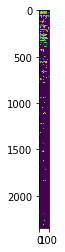

In [86]:
plt.imshow(ratings)
plt.show()

In [87]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity/= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 11.88%


## Separate into train and test data sets

In [88]:
# Custom train_test_split written by EvanRosenthal

def train_test_split(ratings, thresh):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in np.arange(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=thresh, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

Despite our efforts there are still users with too few of a diversity in their reviews. So we must cut them, sorry not sorry users

In [89]:
weak = []
for user in np.arange(ratings.shape[0]):
    chck = len(ratings[user, :].nonzero()[0])
    if chck < 5:
        weak.append(user)

del chck

In [90]:
ratings = np.delete(ratings, weak, axis = 0)

In [91]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity/= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

del sparsity

Sparsity: 26.36%


In [92]:
train, test = train_test_split(ratings, thresh = 5)

# Collaborative Filtering Time!!!!

In [93]:
def slow_similarity(ratings, kind='user'):
    if kind == 'user':
        axmax = 0
        axmin = 1
    elif kind == 'item':
        axmax = 1
        axmin = 0
    sim = np.zeros((ratings.shape[axmax], ratings.shape[axmax]))
    for u in np.arange(ratings.shape[axmax]):
        for uprime in np.arange(ratings.shape[axmax]):
            rui_sqrd = 0.
            ruprimei_sqrd = 0.
            for i in np.arange(ratings.shape[axmin]):
                sim[u, uprime] = ratings[u, i] * ratings[uprime, i]
                rui_sqrd += ratings[u, i] ** 2
                ruprimei_sqrd += ratings[uprime, i] ** 2
            sim[u, uprime] /= rui_sqrd * ruprimei_sqrd
    return sim

def fast_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [94]:
%timeit slow_similarity(train)

## This takes TOO long.
## A useful technical lesson from Evan.
## DON'T use this approach

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


KeyboardInterrupt: 

In [95]:
%timeit fast_similarity(train, kind='user')

5.17 ms ± 23.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [96]:
user_similarity = fast_similarity(train, kind='user')
item_similarity = fast_similarity(train, kind='item')
print(item_similarity[:4, :4])

[[1.         0.43324506 0.45116967 0.43172254]
 [0.43324506 1.         0.50778665 0.49634823]
 [0.45116967 0.50778665 1.         0.62770747]
 [0.43172254 0.49634823 0.62770747 1.        ]]


In [97]:
def predict_slow_simple(ratings, similarity, kind='user'):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in np.arange(ratings.shape[0]):
            for j in np.arange(ratings.shape[1]):
                pred[i, j] = similarity[i, :].dot(ratings[:, j])\
                             /np.sum(np.abs(similarity[i, :]))
        return pred
    elif kind == 'item':
        for i in np.arange(ratings.shape[0]):
            for j in np.arange(ratings.shape[1]):
                pred[i, j] = similarity[j, :].dot(ratings[i, :].T)\
                             /np.sum(np.abs(similarity[j, :]))

        return pred

def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [98]:
%timeit predict_slow_simple(train, user_similarity, kind='user')

975 ms ± 22.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [99]:
%timeit predict_fast_simple(train, user_similarity, kind='user')

3.28 ms ± 36 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [100]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [101]:
item_prediction = predict_fast_simple(train, item_similarity, kind='item')
user_prediction = predict_fast_simple(train, user_similarity, kind='user')

print('User-based CF MSE: ' + str(get_mse(user_prediction, test)))
print('Item-based CF MSE: ' + str(get_mse(item_prediction, test)))

User-based CF MSE: 6.279590555978311
Item-based CF MSE: 10.225124178959733


These values appear to be quite good!

We should push deeper and see if we can improve.

This could be an excellent benchmark once we have the complete dataset compiled

## Trying to improve predictions

### Top k-nearest neighbor

In [102]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in np.arange(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in np.arange(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in np.arange(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in np.arange(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [103]:
pred = predict_topk(train, user_similarity, kind='user', k=40)
print('Top-k User-based CF MSE: ' + str(get_mse(pred, test)))

pred = predict_topk(train, item_similarity, kind='item', k=40)
print('Top-k Item-based CF MSE: ' + str(get_mse(pred, test)))


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Top-k User-based CF MSE: 7.098915764724758


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Top-k Item-based CF MSE: 9.022888936101165


Looks like it will improve things

In [104]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

for k in k_array:
    user_pred = predict_topk(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)] 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an erro

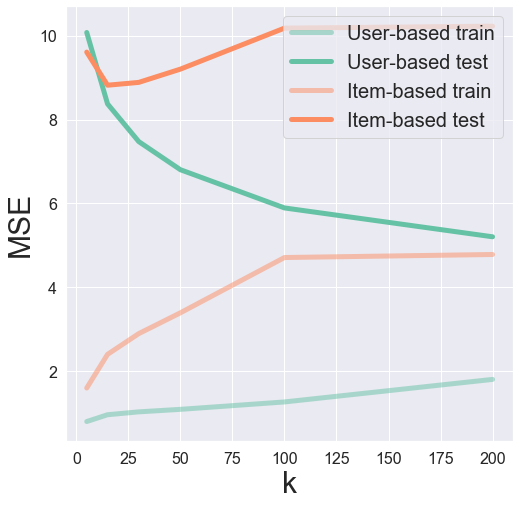

In [105]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

### Removing bias

In [106]:
def predict_nobias(ratings, similarity, kind='user'):
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
        pred += user_bias[:, np.newaxis]
    elif kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        pred += item_bias[np.newaxis, :]
        
    return pred

In [108]:
user_pred = predict_nobias(train, user_similarity, kind='user')
print('Bias-subtracted User-based CF MSE: ' + str(get_mse(user_pred, test)))

item_pred = predict_nobias(train, item_similarity, kind='item')
print('Bias-subtracted Item-based CF MSE: ' + str(get_mse(item_pred, test)))

Bias-subtracted User-based CF MSE: 8.309344243573545
Bias-subtracted Item-based CF MSE: 8.657780222959323


### Combine the approaches

In [109]:
def predict_topk_nobias(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        for i in np.arange(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in np.arange(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
        pred += user_bias[:, np.newaxis]
    if kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        for j in np.arange(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in np.arange(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items])) 
        pred += item_bias[np.newaxis, :]
        
    return pred

In [110]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

for k in k_array:
    user_pred = predict_topk_nobias(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk_nobias(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)] 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an ar

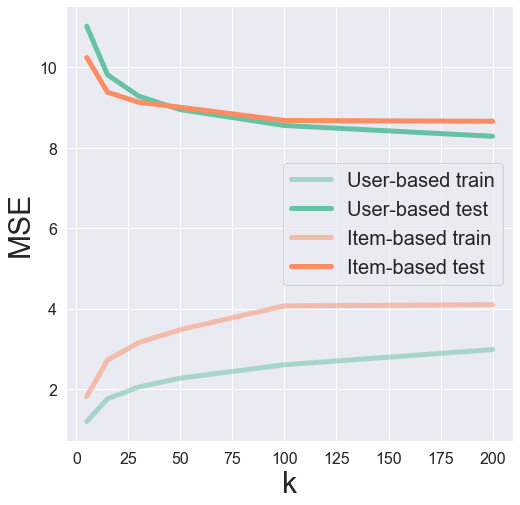

In [111]:
pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);